# Лабораторная работа №1: Первичное исследование данных

## 1. Постановка задачи

### Описание данных
Датасет содержит почасовые данные об аренде велосипедов за определенный период. Включает информацию о дате, погодных условиях (сезон, температура, влажность, ветер) и типах дней (праздничные/рабочие). Главная переменная - количество арендованных велосипедов (`count`).

### Условный заказчик
Сервис велопроката или департамент городского транспорта.

### Возможные задачи ИАД
1. **Прогнозирование спроса:** Предсказание количества велосипедов (`count`) для оптимизации их распределения по станциям.
2. **Поиск аномалий:** Выявление дней с неестественно низким спросом (возможные сбои системы) или аномально высоким спросом (мероприятия, праздники).
3. **Профилирование поведения:** Анализ влияния погоды на разные категории пользователей.

## 2. Паспорт датасета

### 2.1. Загрузка данных

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных
try:
    df = pd.read_csv('../data/bikes_dirty.csv')
    print("Данные загружены.")
except FileNotFoundError:
    print("Файл не найден!")

print(f"Размер датасета: {df.shape[0]} строк, {df.shape[1]} столбцов")

print("\nПервые 5 строк:")
display(df.head())

Данные успешно загружены.


### 2.2. Структура данных

In [24]:
# Информация о столбцах и типах
df.info()

# Статистика по числовым признакам
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10936 entries, 0 to 10935
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10936 non-null  datetime64[ns]
 1   season      10936 non-null  int64         
 2   holiday     10936 non-null  int64         
 3   workingday  10936 non-null  int64         
 4   weather     10391 non-null  float64       
 5   temp        10936 non-null  float64       
 6   atemp       10936 non-null  float64       
 7   humidity    9817 non-null   float64       
 8   windspeed   10614 non-null  float64       
 9   casual      10936 non-null  int64         
 10  registered  10936 non-null  int64         
 11  count       10936 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(6)
memory usage: 1.0 MB


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10936,10936.000000,10936.000000,10936.000000,10391.000000,10936.000000,10936.000000,9817.000000,10614.000000,10936.000000,10936.000000,10936.000000
mean,2011-12-27 05:02:51.506949632,2.506584,0.028987,0.680322,1.419113,20.232915,23.657563,61.915453,12.800656,36.009967,155.418892,191.428859
min,2011-01-01 00:00:00,1.000000,0.000000,0.000000,1.000000,0.820000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2011-07-02 08:45:00,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,2012-01-01 19:30:00,3.000000,0.000000,1.000000,1.000000,20.500000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,2012-07-01 12:15:00,4.000000,0.000000,1.000000,2.000000,26.240000,31.060000,77.000000,16.997900,49.000000,222.000000,283.000000
max,2012-12-19 23:00:00,4.000000,1.000000,1.000000,4.000000,41.000000,45.455000,250.000000,56.996900,367.000000,886.000000,977.000000
std,NaN,1.115773,0.167777,0.466373,0.633654,7.795027,8.479119,19.314763,8.155415,49.943663,151.011931,181.093220


## 3. Аудит качества данных

### 3.1. Пропуски

In [18]:
missing_data = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100

missing_table = pd.concat([missing_data, missing_percent], axis=1, keys=['Total Missing', 'Percent (%)'])
missing_table = missing_table[missing_table['Total Missing'] > 0].sort_values('Percent (%)', ascending=False)

display(missing_table)

,Total Missing,Percent (%)
humidity,1119,10.232260
weather,545,4.983541
windspeed,322,2.944404


### 3.2. Дубликаты

In [25]:
duplicates_count = df.duplicated().sum()
print(f"Количество полных дубликатов строк: {duplicates_count}")

# Проверка дубликатов по времени
time_duplicates = df.duplicated(subset=['datetime']).sum()
print(f"Дубликаты по времени (datetime): {time_duplicates}")

Количество полных дубликатов строк: 50
Дубликаты по времени (datetime): 50


### 3.3. Выбросы

Границы выбросов для 'count': [-319.50, 644.50]
Количество выбросов: 310


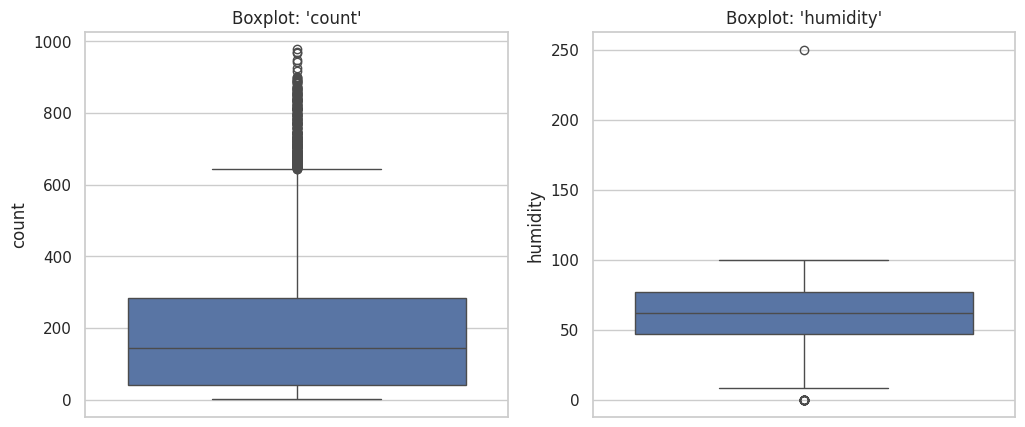

In [22]:
# Анализ выбросов для 'count' методом IQR
Q1 = df['count'].quantile(0.25)
Q3 = df['count'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['count'] < lower_bound) | (df['count'] > upper_bound)]
print(f"Границы выбросов для 'count': [{lower_bound:.2f}, {upper_bound:.2f}]")
print(f"Количество выбросов: {len(outliers)}")

# Визуализация
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y=df['count'])
plt.title("Boxplot: 'count'")

plt.subplot(1, 2, 2)
sns.boxplot(y=df['humidity'])
plt.title("Boxplot: 'humidity'")
plt.show()

## 4. Разведочный анализ

### 4.1. Распределение числового признака

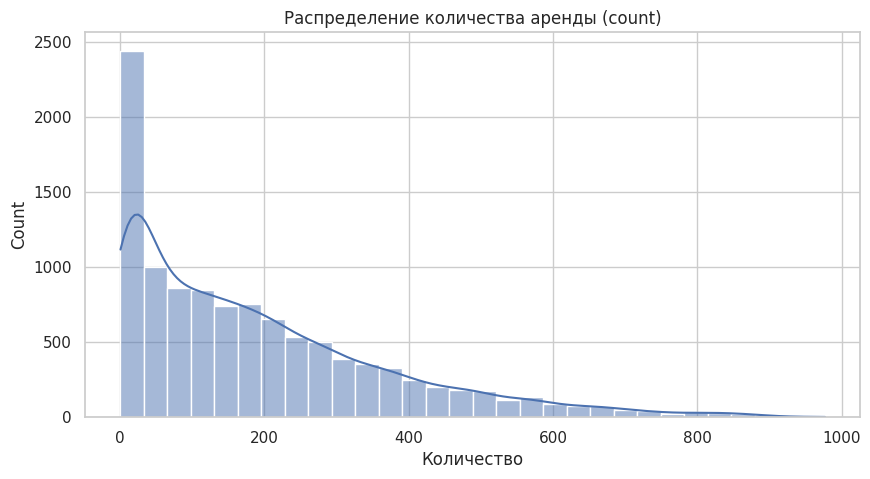

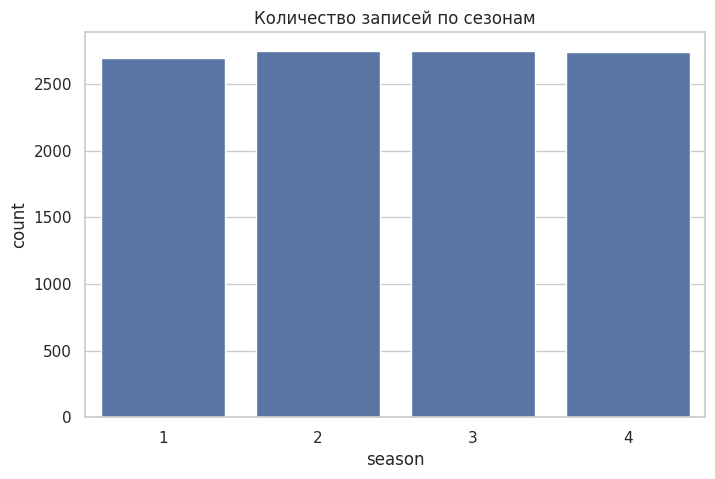

In [26]:
# Распределение целевой переменной
plt.figure(figsize=(10, 5))
sns.histplot(df['count'], kde=True, bins=30)
plt.title('Распределение количества аренды (count)')
plt.xlabel('Количество')
plt.show()

# Распределение категориального признака
plt.figure(figsize=(8, 5))
sns.countplot(x='season', data=df)
plt.title('Количество записей по сезонам')
plt.show()

### 4.2. Взаимосвязи

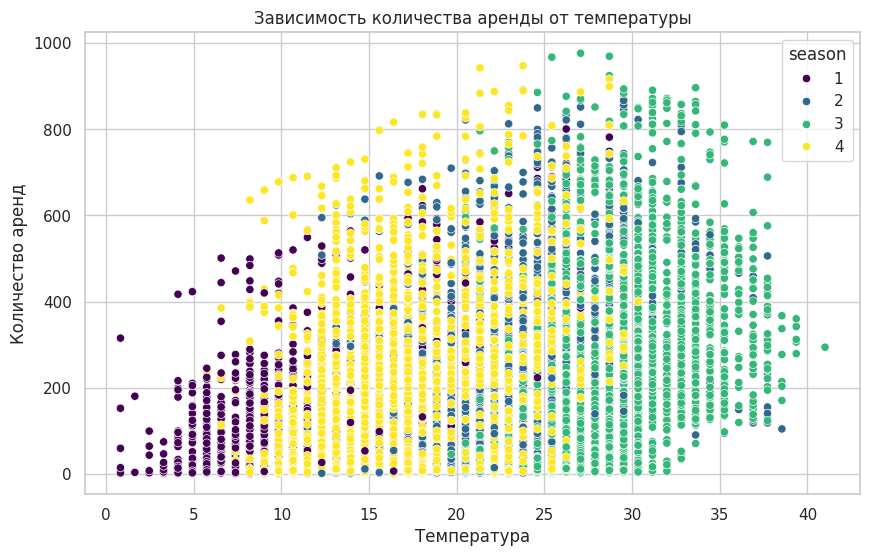

In [10]:
# Зависимость Аренды от Температуры
plt.figure(figsize=(10, 6))
sns.scatterplot(x='temp', y='count', data=df, hue='season', palette='viridis')
plt.title('Зависимость количества аренды от температуры')
plt.xlabel('Температура')
plt.ylabel('Количество аренд')
plt.show()

### 4.2. Выводы
Детали в файле report/quality_report.md